# Import the Important Libraries

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# load the dataset

In [100]:
file_path = 'D:Downloads/iiot_30min_norm.csv'
df = pd.read_csv(file_path)

# Feature Engineering
## Create Lag features and rolling statistics

In [102]:
df['FM1_rolling_mean'] = df['FM1'].rolling(window=3).mean()
df['FM1_lag_1'] = df['FM1'].shift(1)
df['FM1_lag_2'] = df['FM1'].shift(2)
df['hour'] = pd.to_datetime(df['TIME']).dt.hour
df['day'] = pd.to_datetime(df['TIME']).dt.day

# Create the target variable with a refined threshold

In [104]:
failure_threshold = df['FM1'].quantile(0.05)
df['target'] = (df['FM1'].rolling(window=5).min() < failure_threshold).astype(int)
df['target'] = df['target'].shift(-5).fillna(0).astype(int)

# Drop rows with NaN values
## Define Features and Target

In [106]:
df = df.dropna()
X = df[['FM1', 'FM1_rolling_mean', 'FM1_lag_1', 'FM1_lag_2', 'hour', 'day']]
y = df['target']

# Standardize the features

In [108]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#  Apply SMOTE to balance the dataset

In [110]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

#  Train an SVM with class weights to address imbalance

In [26]:
model = SVC(kernel='rbf', class_weight='balanced', C=0.5, random_state=42, probability=True)

# Cross-validation with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Adjust the decision threshold (default is 0.5)
threshold = 0.4
y_pred = (y_probs >= threshold).astype(int)

Cross-Validation Accuracy Scores: [0.960199 0.965    0.935    0.985    0.97    ]
Mean CV Accuracy: 0.9630398009950248


# Evaluate the model

In [29]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.9641434262948207
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       126
           1       0.94      0.99      0.96       125

    accuracy                           0.96       251
   macro avg       0.97      0.96      0.96       251
weighted avg       0.97      0.96      0.96       251



# Confusion Matrix

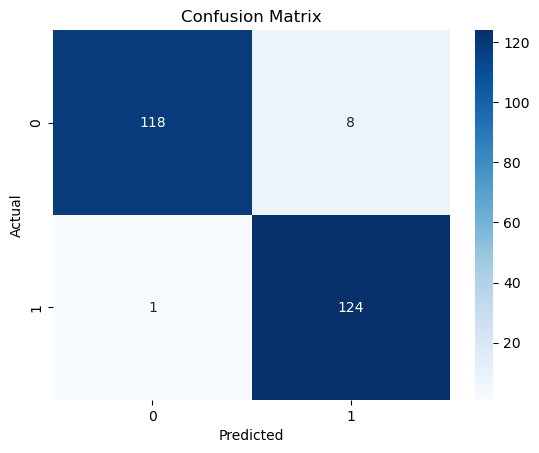

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#  Plot the ROC Curve to analyze the trade-off between sensitivity and specificity

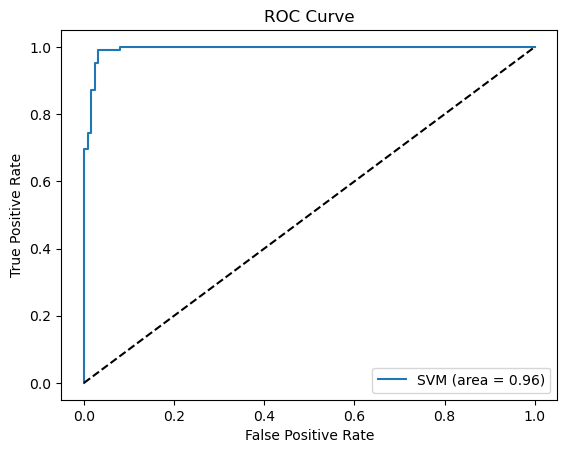

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='SVM (area = {:.2f})'.format(cv_scores.mean()))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# For K-NN Model
## Initialize K-NN model

In [62]:
knn = KNeighborsClassifier()

# Cross-validation with Stratified K-Fold

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.9800995 0.985     0.97      0.99      0.985    ]
Mean CV Accuracy: 0.9820199004975125


# Fit the K-NN Model on training data

In [68]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

# Predict on the test data

In [73]:
y_pred = knn.predict(X_test)

# Evaluate the Model

In [76]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.9800796812749004
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       126
           1       0.96      1.00      0.98       125

    accuracy                           0.98       251
   macro avg       0.98      0.98      0.98       251
weighted avg       0.98      0.98      0.98       251



# Confusion Matrix

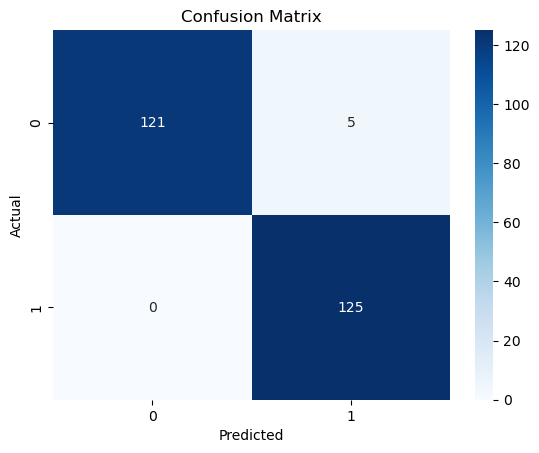

In [79]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Predict probabilities on the test set

In [82]:
y_probs = knn.predict_proba(X_test)[:, 1]

# Plot the ROC Curve to analyze the trade-off between sensitivity and specificity

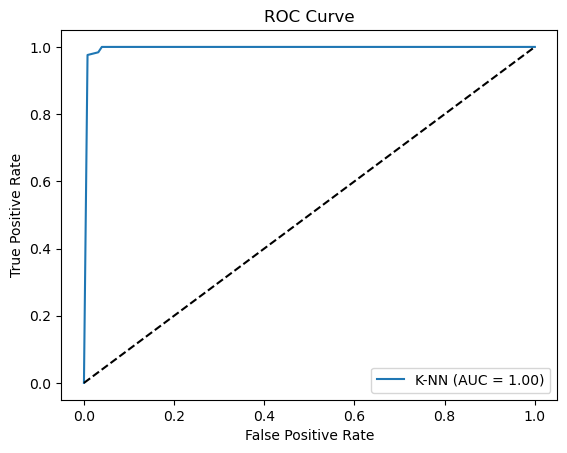

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='K-NN (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


# For Random Forest
## Initialize the Random Forest Model

In [114]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Cross-validation with Stratified K-Fold

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.97014925 0.98       0.96       0.98       0.97      ]
Mean CV Accuracy: 0.9720298507462687


# Fit the Random Forest model on the training data

In [120]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# Predict on the test set

In [123]:
y_pred = rf_model.predict(X_test)

# Evaluate the model

In [126]:
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.9880478087649402
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       126
           1       0.98      0.99      0.99       125

    accuracy                           0.99       251
   macro avg       0.99      0.99      0.99       251
weighted avg       0.99      0.99      0.99       251



# Confusion Matrix

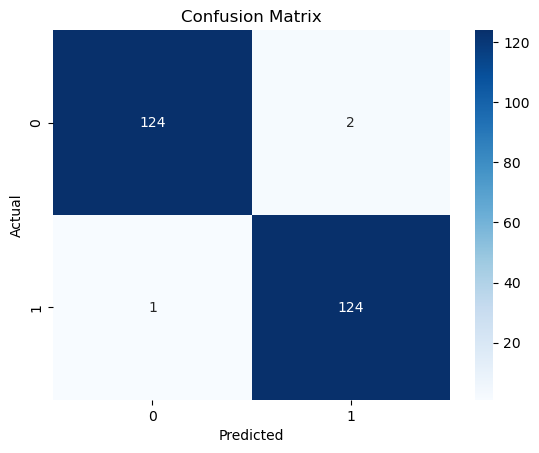

In [133]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Predict probabilities on the test set

In [136]:
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Plot the ROC Curve to analyze the trade-off between sensitivity and specificity

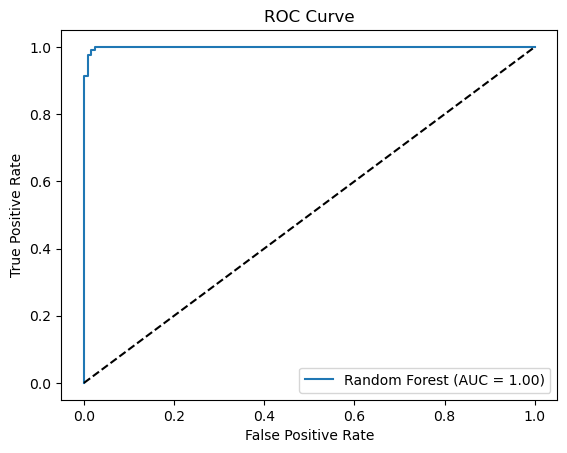

In [139]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()